In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "../00_setup.py").load_module()

# Stellargraph - Binary Classification

Modify stellargraph vignette code to do binary classification on the Cora dataset, to get used to the methodology.


Based on the code in 
https://stellargraph.readthedocs.io/en/stable/demos/node-classification/graphsage-node-classification.html 

Also see 01_stellargraph_vignette.ipynb in this folder!

*This script takes about 2 minutes on my MacBook Air*

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

2023-11-18 13:46:21.889172: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-11-18 13:46:21.889197: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-18 13:46:21.889206: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-18 13:46:21.889243: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-18 13:46:21.889262: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [5]:
import tensorflow.keras.metrics as km
from keras import initializers

## Import data, get binary labels 
Instead of multiclass topics, do "neural network or not?" model

In [6]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [7]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [8]:
# Get a target which indicates whether the subject is or is not neural networks

In [9]:
node_subjects.value_counts()

subject
Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: count, dtype: int64

In [10]:
node_is_nn = pd.Series(np.where(node_subjects == 'Neural_Networks', 1, 0).astype('int'),
                      index=node_subjects.index)

In [11]:
node_is_nn.value_counts()

0    1890
1     818
Name: count, dtype: int64

In [12]:
node_is_nn.value_counts(normalize=True)

0    0.697932
1    0.302068
Name: proportion, dtype: float64

Note:  I notice the train size is quite small - 0.1.  And the model overfits in just a couple epochs.  It seems that not a lot of data is needed to fit this model - features / structure are very predictive.

In [13]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_is_nn.index, train_size=0.1, test_size=None, stratify=node_is_nn
)

In [14]:
train_targets = node_is_nn[train_subjects]
test_targets = node_is_nn[test_subjects]

In [15]:
batch_size = 50
num_samples = [10, 5]

In [16]:
#Added to vignette
np.random.seed(16)
tf.random.set_seed(16)

In [17]:
# Workaround - needs a seed
generator = GraphSAGENodeGenerator(G, batch_size, num_samples, seed=12)

In [18]:
train_gen = generator.flow(train_targets.index, train_targets, shuffle=True)

In [19]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
)

##### Use Sigmoid activation as this is a binary classification now

In [20]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=1, activation="sigmoid",
                         kernel_initializer=initializers.glorot_uniform(seed=99))(x_out) 
# prediction is 1D now
# workaroung - give Keras layer a seed

/Users/valeriecarey/miniconda3/envs/tf_p38/lib/python3.8/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [21]:
x_inp

[<KerasTensor: shape=(None, 1, 1433) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 10, 1433) dtype=float32 (created by layer 'input_2')>,
 <KerasTensor: shape=(None, 50, 1433) dtype=float32 (created by layer 'input_3')>]

In [22]:
x_out

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'lambda')>

In [23]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.005),
    #loss=losses.categorical_crossentropy,
    loss = losses.binary_crossentropy,  # binary model now
    metrics=["acc", km.AUC(), km.Precision(), km.Recall()],
)

In [24]:
test_gen = generator.flow(test_targets.index, test_targets)

In [25]:
history = model.fit(
    train_gen, epochs=20, validation_data=test_gen, verbose=2, shuffle=False
)

Epoch 1/20


2023-11-18 13:46:23.171424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-18 13:46:24.535704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 - 3s - loss: 0.6118 - acc: 0.6889 - auc: 0.5940 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5438 - val_acc: 0.7006 - val_auc: 0.9039 - val_precision: 1.0000 - val_recall: 0.0082 - 3s/epoch - 486ms/step
Epoch 2/20
6/6 - 1s - loss: 0.4944 - acc: 0.7407 - auc: 0.9623 - precision: 1.0000 - recall: 0.1463 - val_loss: 0.4249 - val_acc: 0.8437 - val_auc: 0.9528 - val_precision: 0.9216 - val_recall: 0.5272 - 854ms/epoch - 142ms/step
Epoch 3/20
6/6 - 1s - loss: 0.3973 - acc: 0.9111 - auc: 0.9720 - precision: 0.9677 - recall: 0.7317 - val_loss: 0.3550 - val_acc: 0.8958 - val_auc: 0.9533 - val_precision: 0.8608 - val_recall: 0.7812 - 833ms/epoch - 139ms/step
Epoch 4/20
6/6 - 1s - loss: 0.3146 - acc: 0.9556 - auc: 0.9781 - precision: 0.9487 - recall: 0.9024 - val_loss: 0.3175 - val_acc: 0.9036 - val_auc: 0.9583 - val_precision: 0.8744 - val_recall: 0.7948 - 844ms/epoch - 141ms/step
Epoch 5/20
6/6 - 1s - loss: 0.2654 - acc: 0.9481 - auc: 0.9872 - precision: 0.9359 - recall: 0.890

In [26]:
# Overfitting 

In [27]:
pd.DataFrame(history.history).tail(3)

,loss,acc,auc,precision,recall,val_loss,val_acc,val_auc,val_precision,val_recall
17,0.050300,0.996296,1.0,0.987952,1.00000,0.325356,0.894176,0.939781,0.868827,0.764946
18,0.054344,0.992593,1.0,1.000000,0.97561,0.314173,0.894586,0.941468,0.851689,0.788043
19,0.048263,1.000000,1.0,1.000000,1.00000,0.317024,0.894176,0.938290,0.831025,0.815217


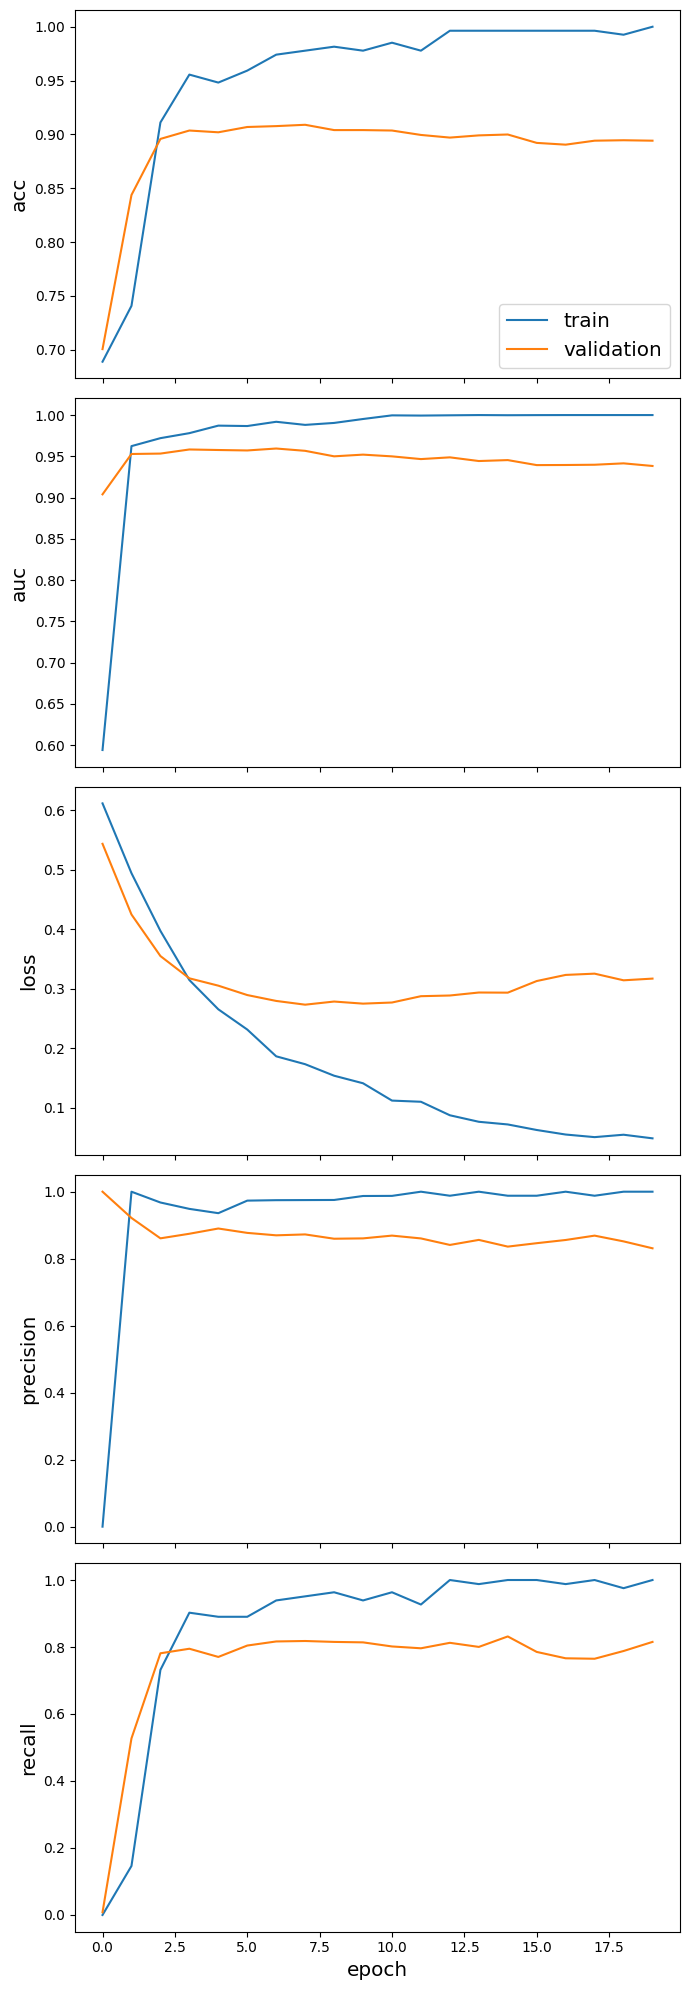

In [28]:
sg.utils.plot_history(history)

In [29]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

49/49 [==============================] - 1s 15ms/step - loss: 0.3231 - acc: 0.8913 - auc: 0.9347 - precision: 0.8239 - recall: 0.8139

Test Set Metrics:
	loss: 0.3231
	acc: 0.8913
	auc: 0.9347
	precision: 0.8239
	recall: 0.8139


In [30]:
train_metrics = model.evaluate(train_gen)
print("\Train Set Metrics:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

6/6 [==============================] - 0s 44ms/step - loss: 0.0355 - acc: 1.0000 - auc: 1.0000 - precision: 1.0000 - recall: 1.0000
\Train Set Metrics:
	loss: 0.0355
	acc: 1.0000
	auc: 1.0000
	precision: 1.0000
	recall: 1.0000


In [31]:
metrics = pd.concat([pd.DataFrame(dict(zip(model.metrics_names, [[t] for t in train_metrics]))),
                         pd.DataFrame(dict(zip(model.metrics_names, [[t] for t in test_metrics])))],
                        keys=['train', 'test'])
metrics

,,loss,acc,auc,precision,recall
train,0,0.035535,1.000000,1.000000,1.000000,1.000000
test,0,0.323051,0.891304,0.934691,0.823934,0.813859


## Predictions

In [32]:
index_list = [c for c in test_subjects] + [c for c in train_subjects]

In [33]:
test_subjects

Index([ 173863, 1116268, 1153942,  159085,  323128,  242663,  594119,   14531,
        261040, 1123576,
       ...
       1117089,     164, 1125992, 1114777,   38722, 1120049,   90470, 1120169,
         93755,  899085],
      dtype='int64', length=2438)

In [34]:
all_targ = np.concatenate((test_targets, train_targets),axis=0)

In [35]:
all_gen = generator.flow(index_list, all_targ)

In [36]:
all_predictions = model.predict(all_gen)

 6/55 [==>...........................] - ETA: 0s 

2023-11-18 13:46:43.708177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 1s 13ms/step


In [37]:
all_predictions.flatten()

array([0.03161141, 0.9533831 , 0.02703332, ..., 0.9577552 , 0.02938518,
       0.0288856 ], dtype=float32)

In [38]:
# Don't tune a decision threshold...
bin_predictions = np.where(all_predictions.flatten() >= 0.5, 1, 0)

In [39]:
bin_predictions

array([0, 1, 0, ..., 1, 0, 0])

In [40]:
np.concatenate((test_subjects.values, train_subjects.values))

array([ 173863, 1116268, 1153942, ...,   60159,  149139,  510718])

In [41]:
df = pd.DataFrame({"Predicted": bin_predictions, 
                   "True": all_targ})
df.index = index_list   # Having the right index is helpful for later steps
df.head(10)

,Predicted,True
173863,0,0
1116268,1,0
1153942,0,0
159085,1,1
323128,0,0
242663,0,0
594119,0,0
14531,0,0
261040,0,0
1123576,1,1


In [42]:
pd.crosstab(bin_predictions, all_targ)

col_0,0,1
row_0,,
0,1760,136
1,130,682


## Node embeddings

In [43]:
embedding_model = Model(inputs=x_inp, outputs=x_out)

As above, the code below needed to be modified.  Their "all_mapper" is my "all_gen"

In [44]:
emb = embedding_model.predict(all_gen)
emb.shape

 7/55 [==>...........................] - ETA: 0s

2023-11-18 13:46:44.693137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


55/55 [==============================] - 1s 12ms/step


(2708, 32)

###### Project the embeddings to 2d using either TSNE or PCA transform, and visualise, coloring nodes by their subject label

Minor modifications are again needed due to workarounds above

In [45]:
X = emb
#y = np.argmax(target_encoding.transform(node_subjects), axis=1)
y = all_targ

In [46]:
X.shape[1]

32

In [47]:
if X.shape[1] > 2:
    transform = TSNE  # PCA

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=df.index) # workaround
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=node_subjects)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y

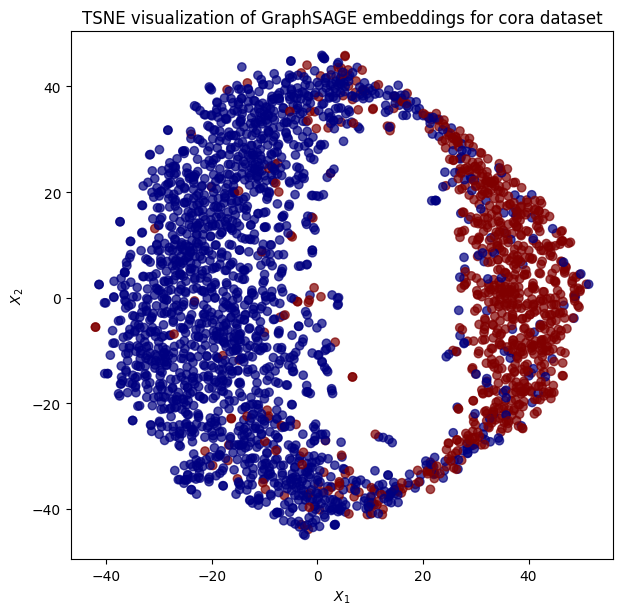

In [48]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GraphSAGE embeddings for cora dataset".format(transform.__name__)
)
plt.show()

Whoa!  That is wild looking!   Try PCA

In [49]:
if X.shape[1] > 2:
    transform = PCA  # Changed it!

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=df.index) # workaround
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=node_subjects)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y

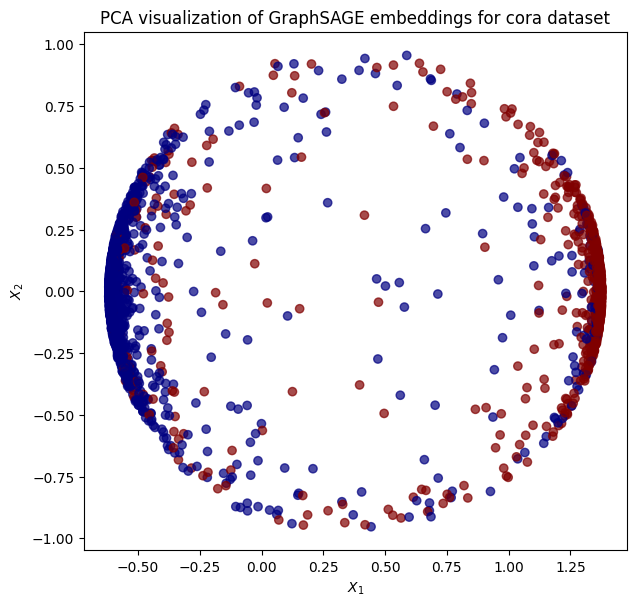

In [50]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GraphSAGE embeddings for cora dataset".format(transform.__name__)
)
plt.show()

Holy macaroni I wonder why it's a circle

I want to re-do parts of this analysis, changing things like the number of neighbors sampled and the learning rate, to see whether the fit changes

In [59]:
model.metrics_names

['loss', 'acc', 'auc', 'precision', 'recall']

In [ ]:
# data sets
https://stellargraph.readthedocs.io/en/v1.2.0/api.html

In [63]:
dir(datasets)

['AIFB',
 'BlogCatalog3',
 'CiteSeer',
 'Cora',
 'DatasetLoader',
 'FB15k',
 'FB15k_237',
 'IAEnronEmployees',
 'METR_LA',
 'MUTAG',
 'MovieLens',
 'PROTEINS',
 'PubMedDiabetes',
 'StellarDiGraph',
 'StellarGraph',
 'WN18',
 'WN18RR',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'dataset_loader',
 'datasets',
 'experimental',
 'itertools',
 'log',
 'logging',
 'np',
 'os',
 'pd',
 'preprocessing']